In [1]:
pip install imblearn

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaModel, RobertaTokenizer
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset shape: (4999, 6)


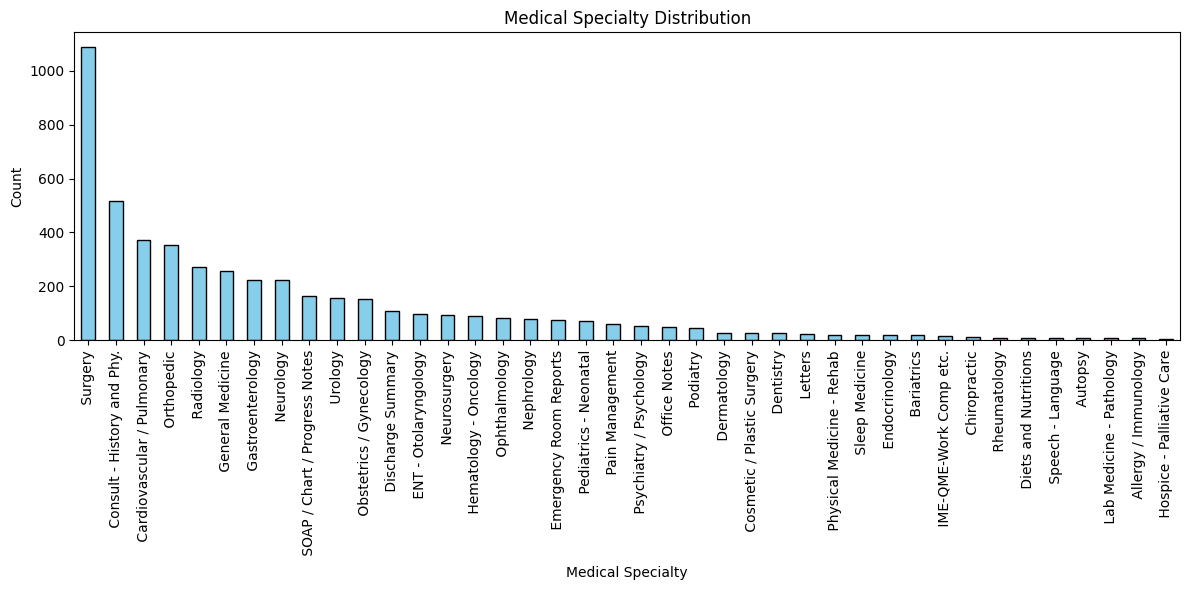

In [4]:
df = pd.read_csv("/content/mtsamples.csv")
print(f"Dataset shape: {df.shape}")

# Data Cleaning and Preprocessing
df = df.dropna(subset=['transcription', 'medical_specialty'])
df['medical_specialty_code'] = pd.factorize(df['medical_specialty'])[0]

# Visualize class distribution
plt.figure(figsize=(12, 6))
df['medical_specialty'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Medical Specialty Distribution')
plt.xlabel('Medical Specialty')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Prepare Data
X = df['transcription'].tolist()
y = df['medical_specialty_code'].tolist()

In [5]:
# Tokenizer and Model Initialization
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenization
def tokenize_data(texts, tokenizer, max_length=256):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=max_length
    )

inputs = tokenize_data(X, tokenizer)

Generating embeddings...
Applying SMOTE for class balancing...
Training model...
Epoch 1/30, Train Loss: 1.8495, Val Loss: 1.1292
Epoch 2/30, Train Loss: 0.9600, Val Loss: 0.8515
Epoch 3/30, Train Loss: 0.7873, Val Loss: 0.7124
Epoch 4/30, Train Loss: 0.6954, Val Loss: 0.7107
Epoch 5/30, Train Loss: 0.6420, Val Loss: 0.6417
Epoch 6/30, Train Loss: 0.5963, Val Loss: 0.6086
Epoch 7/30, Train Loss: 0.5665, Val Loss: 0.5639
Epoch 8/30, Train Loss: 0.5392, Val Loss: 0.5724
Epoch 9/30, Train Loss: 0.5251, Val Loss: 0.5636
Epoch 10/30, Train Loss: 0.5054, Val Loss: 0.5690
Epoch 11/30, Train Loss: 0.4921, Val Loss: 0.5561
Epoch 12/30, Train Loss: 0.4810, Val Loss: 0.5559
Epoch 13/30, Train Loss: 0.4731, Val Loss: 0.5557
Epoch 14/30, Train Loss: 0.4649, Val Loss: 0.5303
Epoch 15/30, Train Loss: 0.4566, Val Loss: 0.5061
Epoch 16/30, Train Loss: 0.4484, Val Loss: 0.4938
Epoch 17/30, Train Loss: 0.4397, Val Loss: 0.5266
Epoch 18/30, Train Loss: 0.4365, Val Loss: 0.4807
Epoch 19/30, Train Loss: 0.4

<ipython-input-7-11333c16c85d>:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       227
           1       0.98      1.00      0.99       220
           2       0.66      0.59      0.62       229
           3       0.63      0.43      0.51       211
           4       0.96      0.98      0.97       207
           5       0.81      0.84      0.82       208
           6       0.71      0.33      0.45       210
           7       0.23      0.04      0.06       239
           8       0.96      1.00      0.98       225
           9       0.66      0.70      0.68       220
          10       0.94      1.00      0.97       216
          11       0.97      0.99      0.98       212
          12       0.47      0.63      0.54       222
          13       0.87      0.95      0.91       203
          14       0.88      0.94      0.91       209
          15       0.89      1.00      0.94       214
          16       0.82      0.91      0.86       232
    

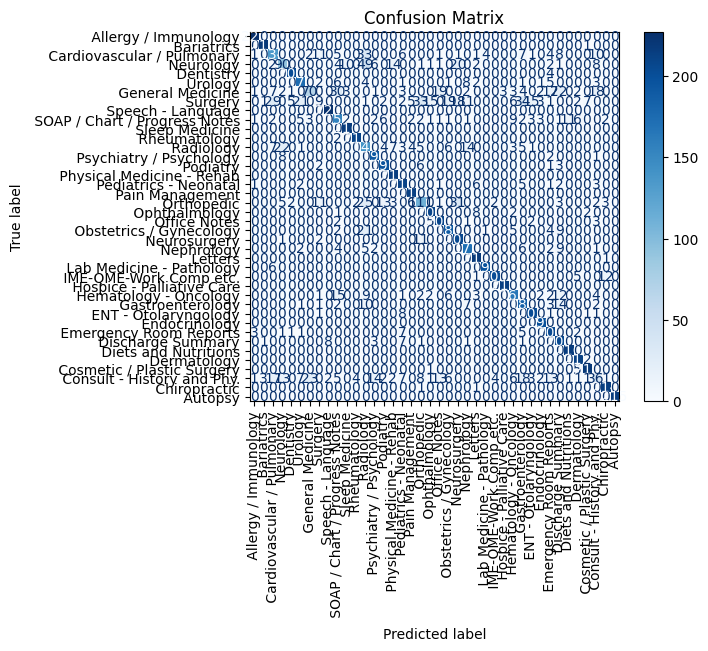

Model training and evaluation complete.


In [7]:
# Generate Embeddings
def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, inputs['input_ids'].size(0), batch_size):
            batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
            batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

print("Generating embeddings...")
embeddings = generate_embeddings(model, inputs)

# Handle Class Imbalance with SMOTE
print("Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
embeddings_resampled, labels_resampled = smote.fit_resample(embeddings, y)

# Train-Test-Validation Split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Data Loaders
batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Model Initialization
input_dim = embeddings.shape[1]
hidden_dim = 128
num_classes = len(df['medical_specialty'].unique())
model = MLPClassifier(input_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 30
best_val_loss = float('inf')

print("Training model...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

# Evaluation
print("Evaluating model...")
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['medical_specialty'].unique())
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Save Final Model
torch.save(model.state_dict(), "final_model.pth")
print("Model training and evaluation complete.")
